In [ ]:
!pip install optuna

# Датасет

In [ ]:
!cp drive/MyDrive/us_cities.csv ./us_cities.csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

feature = 'State'
train_ratio = 0.8

df = pd.read_csv('us_cities.csv')
df = df.dropna(ignore_index=True)
target = pd.Series(pd.factorize(df[feature])[0])
df = df.iloc[:, 6:]
for column in df:
    mean = df[column].mean()
    std = df[column].std()
    outliers = np.where((df[column] - mean) / std >= 3)[0]
    df = df.drop(index=outliers).reset_index(drop=True)
    target = target.drop(index=outliers).reset_index(drop=True)

df = (df - df.mean()) / df.std()
print(df.info())
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=train_ratio)
print(X_train.info())
print(X_test.info())
print(y_train.info())
print(y_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14648 entries, 0 to 14647
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Latitude               14648 non-null  float64
 1   Longitude              14648 non-null  float64
 2   Population             14648 non-null  float64
 3   Asian                  14648 non-null  float64
 4   White                  14648 non-null  float64
 5   Black                  14648 non-null  float64
 6   Indian                 14648 non-null  float64
 7   Hispanic               14648 non-null  float64
 8   Hawaiian               14648 non-null  float64
 9   Other                  14648 non-null  float64
 10  Females                14648 non-null  float64
 11  Males                  14648 non-null  float64
 12  Median_age             14648 non-null  float64
 13  Median_female_age      14648 non-null  float64
 14  Median_male_age        14648 non-null  float64
 15  Ho

# Вспомогательные функции для ядер и метрик

In [ ]:
def get_kernel(kernel_name, a=1, b=1):
    match kernel_name:
        case 'uniform':
            return lambda x: 0.5 * (1 if x < 1 else 0)
        case 'gaussian':
            return lambda x: 1 / np.sqrt(2 * np.pi) * np.exp(- x * x / 2)
        case 'triangular':
            return lambda x: (1 - np.abs(x)) * (1 if x < 1 else 0)
        case 'epanechnikov':
            return lambda x: 0.75 * (1 - x ** 2) * (1 if x < 1 else 0)
        case 'biquadratic':
            return lambda x: 0.9375 * (1 - x ** 2) ** 2 * (1 if x < 1 else 0)
        case 'common':
            return lambda x: (1 - np.abs(x) ** a) ** b * (1 if x < 1 else 0)
        case _:
            raise Exception('Unknown kernel specified: '
                            'uniform, gaussian, triangular, epanechnikov, biquadratic or common are available.')

In [ ]:
from sklearn.metrics import DistanceMetric


def get_metric(metric_name, p=2):
    if metric_name == 'minkowski':
        return DistanceMetric.get_metric('minkowski', p=p)
    elif metric_name == 'cosine':
        return DistanceMetric.get_metric(
            'pyfunc',
            func=lambda x, y: 1 - np.inner(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
        )
    elif metric_name in ['manhattan', 'euclidean', 'chebyshev', 'minkowski']:
        return DistanceMetric.get_metric(metric_name)
    else:
        raise Exception('Unknown metric specified: '
                        'manhattan, euclidean, chebyshev, minkowski or cosine are available.')

# Реализация kNN

In [ ]:
from sklearn.neighbors import BallTree


class KnnClassifier:
    neighbors_number = 1
    window_type = None
    h = 1
    kernel_function = None
    metric = None
    tree = None
    values = None
    weights = None
    features_number = 0

    def __init__(self,
                 neighbors_number,
                 window_type='unfixed',
                 h=1,
                 kernel='uniform',
                 a=1,
                 b=1,
                 metric='minkowski',
                 p=2):
        self.neighbors_number = neighbors_number
        if window_type not in ['fixed', 'unfixed']:
            raise Exception('Unknown window type specified: fixed or unfixed are available.')
        self.window_type = window_type
        self.h = h
        self.metric = get_metric(metric, p)
        self.kernel_function = get_kernel(kernel, a, b)

    def fit(self, X, y, w=None):
        self.tree = BallTree(X, metric=self.metric)
        self.values = y
        self.weights = w
        self.features_number = len(y.unique())

    def predict(self, X):
        preds = [0.0] * X.shape[0]
        for i in range(X.shape[0]):
            if self.window_type == 'fixed':
                ind, dist = self.tree.query_radius([X.iloc[i].values], self.h, return_distance=True)
                ind, dist = ind[0], dist[0]
                h = self.h
            else:
                dist, ind = self.tree.query([X.iloc[i].values], self.neighbors_number + 1, return_distance=True)
                dist, ind = dist[0], ind[0]
                h = dist[-1]
            feature_factors = [0.0] * self.features_number

            for j, k in enumerate(ind):
                try:
                    weight = 1 if self.weights is None else self.weights[k]
                    factor = self.kernel_function(dist[j] / h) * weight
                    feature_factors[self.values.iloc[k]-1] += factor
                except IndexError:
                    raise IndexError("Index error occurred in section with weights")
            preds[i] = np.argmax(feature_factors)
        return preds

# Подбор гиперпараметров

In [ ]:
import optuna
from sklearn.metrics import accuracy_score

train_size = int(X_train.shape[0] * train_ratio)
train_data = X_train[: train_size]
valid_data = X_train[train_size:]
train_target = y_train[: train_size]
valid_target = y_train[train_size :]

In [ ]:
def my_objective(trial):
    neighbors = trial.suggest_int('neighbors', 1, 50, log=True)
    window = trial.suggest_categorical('window', ['fixed', 'unfixed'])
    kernel = trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'common'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'chebyshev', 'cosine'])
    h, a, b, p = 1, 1, 1, 1
    if window == 'fixed':
        h = trial.suggest_float('h', 1e-2, 1e2, log=True)
    if kernel == 'common':
        a = trial.suggest_int('a', 1, 4)
        b = trial.suggest_int('b', 1, 4)
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 4)
    classifier = KnnClassifier(neighbors, window, h, kernel, a, b, metric, p)
    classifier.fit(train_data, train_target)
    return accuracy_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=100)
print(study.best_params)

[I 2024-10-16 21:40:09,137] A new study created in memory with name: no-name-2ccf61f4-cb1d-4b5f-adfa-d4031bf9f2ba
[I 2024-10-16 21:40:10,663] Trial 0 finished with value: 0.0 and parameters: {'neighbors': 7, 'window': 'fixed', 'kernel': 'gaussian', 'metric': 'minkowski', 'h': 0.0842992866468662, 'p': 2}. Best is trial 0 with value: 0.0.
[I 2024-10-16 21:40:12,163] Trial 1 finished with value: 0.0 and parameters: {'neighbors': 2, 'window': 'fixed', 'kernel': 'common', 'metric': 'minkowski', 'h': 0.05901378695597417, 'a': 4, 'b': 1, 'p': 1}. Best is trial 0 with value: 0.0.
[I 2024-10-16 21:40:30,743] Trial 2 finished with value: 0.014931740614334471 and parameters: {'neighbors': 4, 'window': 'unfixed', 'kernel': 'uniform', 'metric': 'minkowski', 'p': 4}. Best is trial 2 with value: 0.014931740614334471.
[I 2024-10-16 21:42:53,658] Trial 3 finished with value: 0.014078498293515358 and parameters: {'neighbors': 11, 'window': 'unfixed', 'kernel': 'common', 'metric': 'cosine', 'a': 4, 'b': 

{'neighbors': 37, 'window': 'unfixed', 'kernel': 'uniform', 'metric': 'chebyshev'}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def sklearn_objective(trial):
    neighbors = trial.suggest_int('neighbors', 1, 50, log=True)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine'])
    p = 1
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 4)
    classifier = KNeighborsClassifier(neighbors, weights=weights, metric=metric, p=p, n_jobs=1)
    classifier.fit(train_data, train_target)
    return accuracy_score(valid_target, classifier.predict(valid_data))

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-10-16 22:40:08,281] A new study created in memory with name: no-name-6a2c6f38-96e1-4591-ba0c-2e2aa401c4e6
[I 2024-10-16 22:40:08,990] Trial 0 finished with value: 0.5298634812286689 and parameters: {'neighbors': 3, 'weights': 'distance', 'metric': 'cosine'}. Best is trial 0 with value: 0.5298634812286689.
[I 2024-10-16 22:40:09,434] Trial 1 finished with value: 0.5034129692832765 and parameters: {'neighbors': 1, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 0 with value: 0.5298634812286689.
[I 2024-10-16 22:40:10,147] Trial 2 finished with value: 0.5217576791808873 and parameters: {'neighbors': 14, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 0 with value: 0.5298634812286689.
[I 2024-10-16 22:40:11,259] Trial 3 finished with value: 0.49445392491467577 and parameters: {'neighbors': 2, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1}. Best is trial 0 with value: 0.5298634812286689.
[I 2024-10-16 22:40:12,084] Trial 4 finished with value: 0.5098122866894

{'neighbors': 15, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}


My:
```
{'neighbors': 37, 'window': 'unfixed', 'kernel': 'uniform', 'metric': 'chebyshev'}
```
sklearn:
```
{'neighbors': 15, 'weights': 'distance', 'metric': 'minkowski', 'p': 1}
```

# Различное число соседей

In [ ]:
neighbors_range = range(1, 51)
size = len(neighbors_range)

my_train_accuracy = [0.0] * size
my_test_accuracy = [0.0] * size
classifier = KnnClassifier(1, window_type='unfixed', kernel='uniform', metric='chebyshev')
classifier.fit(X_train, y_train)
for neighbors in neighbors_range:
    classifier.neighbors_number = neighbors
    my_train_accuracy[neighbors - 1] = accuracy_score(y_train, classifier.predict(X_train))
    my_test_accuracy[neighbors - 1] = accuracy_score(y_test, classifier.predict(X_test))

sklearn_train_accuracy = [0.0] * size
sklearn_test_accuracy = [0.0] * size
for neighbors in neighbors_range:
    classifier = KNeighborsClassifier(neighbors, weights='distance', metric='minkowski', p=1, n_jobs=1)
    classifier.fit(X_train, y_train)
    sklearn_train_accuracy[neighbors - 1] = accuracy_score(y_train, classifier.predict(X_train))
    sklearn_test_accuracy[neighbors - 1] = accuracy_score(y_test, classifier.predict(X_test))

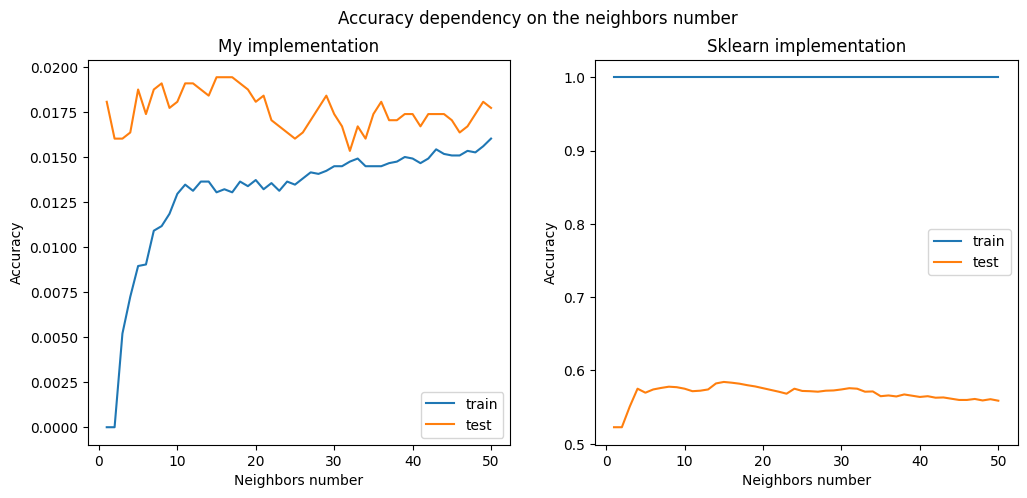

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Accuracy dependency on the neighbors number')
ax[0].set_title('My implementation')
ax[0].set_xlabel('Neighbors number')
ax[0].set_ylabel('Accuracy')
ax[0].plot(neighbors_range, my_train_accuracy, label='train')
ax[0].plot(neighbors_range, my_test_accuracy, label='test')
ax[0].legend()

ax[1].set_title('Sklearn implementation')
ax[1].set_xlabel('Neighbors number')
ax[1].set_ylabel('Accuracy')
ax[1].plot(neighbors_range, sklearn_train_accuracy, label='train')
ax[1].plot(neighbors_range, sklearn_test_accuracy, label='test')
ax[1].legend()

# LOWESS

In [ ]:
class Lowess:
    neighbors_number = 1
    knn_kernel = None
    lowess_kernel = None
    metric = None

    def __init__(self,
                 neighbors_number,
                 knn_kernel='uniform',
                 lowess_kernel='uniform',
                 knn_a=1,
                 knn_b=1,
                 lowess_a=1,
                 lowess_b=1,
                 metric='minkowski',
                 p=2):
        self.neighbors_number = neighbors_number
        self.metric = get_metric(metric, p)
        self.knn_kernel = get_kernel(knn_kernel, knn_a, knn_b)
        self.lowess_kernel = get_kernel(lowess_kernel, lowess_a, lowess_b)

    def get_weights(self, X, y):
        tree = BallTree(X, metric=self.metric)
        features_number = len(y.unique())
        lowess_weights = [0.0] * X.shape[0]
        for i in range(X.shape[0]):
            dist, ind = tree.query([X.iloc[i].values], self.neighbors_number + 1, return_distance=True)
            dist, ind = dist[0][1:], ind[0][1:]
            h = dist[-1]
            feature_factors = [0.0] * features_number
            for j in range(len(ind)):
                try:
                    factor = self.knn_kernel(dist[j] / h)
                    feature_factors[y.iloc[ind[j]]-1] += factor
                except IndexError:
                    print(f'{len(feature_factors)=}, {feature_factors=}')
                    print(f'{y.iloc[ind[j]]=}')
                    raise ArithmeticError("EEEEEEEEEEEEEE")
            feature_factors /= np.linalg.norm(feature_factors)
            lowess_weights[i] = self.lowess_kernel(1 - feature_factors[y.iloc[i]-1])
        return lowess_weights


In [ ]:
from sklearn.metrics import accuracy_score

lowess = Lowess(neighbors_number=37, knn_kernel='uniform', lowess_kernel='uniform', metric='chebyshev')
weights = lowess.get_weights(X_train, y_train)

## My kNN

In [ ]:
classifier = KnnClassifier(neighbors_number=37, window_type='unfixed', kernel='uniform', metric='chebyshev')

classifier.fit(X_train, y_train)
print('До взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

classifier.fit(X_train, y_train, weights)
print('После взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

До взвешивания:  0.017064846416382253
После взвешивания:  0.017064846416382253


## sklearn kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

oversampled_X_train = X_train.sample(frac=10, replace=True, weights=weights, random_state=42)
oversampled_y_train = y_train.sample(frac=10, replace=True, weights=weights, random_state=42)
classifier = KNeighborsClassifier(15, weights='distance', metric='minkowski', p=1, n_jobs=1)
classifier.fit(X_train, y_train)
print('До взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

classifier.fit(oversampled_X_train, oversampled_y_train)
print('После взвешивания: ', accuracy_score(y_test, classifier.predict(X_test)))

До взвешивания:  0.5843003412969283
После взвешивания:  0.5215017064846417
